# 📌BOAZ 18기 분석 Base 2주차 세션 실습자료

과대적합, 과소적합을 시각화해서 보기 위한 예제입니다.(딥러닝 코드에 대해 자세히 이해하지 못해도 괜찮습니다.)

In [5]:
from keras.utils import np_utils
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## 과대적합

In [6]:
 
# 훈련셋과 시험셋 로딩
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# 훈련셋과 검증셋 분리
X_val = X_train[50000:]
Y_val = Y_train[50000:]
X_train = X_train[:50000]
Y_train = Y_train[:50000]

X_train = X_train.reshape(50000, 784).astype('float32') / 255.0
X_val = X_val.reshape(10000, 784).astype('float32') / 255.0
X_test = X_test.reshape(10000, 784).astype('float32') / 255.0

# 훈련셋, 검증셋 고르기
train_rand_idxs = np.random.choice(50000, 700)
val_rand_idxs = np.random.choice(10000, 300)

X_train = X_train[train_rand_idxs]
Y_train = Y_train[train_rand_idxs]
X_val = X_val[val_rand_idxs]
Y_val = Y_val[val_rand_idxs]

# 라벨링 전환
Y_train = np_utils.to_categorical(Y_train)
Y_val = np_utils.to_categorical(Y_val)
Y_test = np_utils.to_categorical(Y_test)

In [7]:
model = Sequential()
model.add(Dense(units = 2, input_dim = 28 * 28, activation = 'relu'))
model.add(Dense(units = 10, activation = 'softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer = 'Adam', metrics = ['accuracy'])

#모델 학습
hist = model.fit(X_train, Y_train, epochs = 2000, batch_size = 50, 	
                 validation_data=(X_val, Y_val), verbose=0) #verbose=2로 설정하면 실시간 loss, accuracy 확인 가능


No handles with labels found to put in legend.


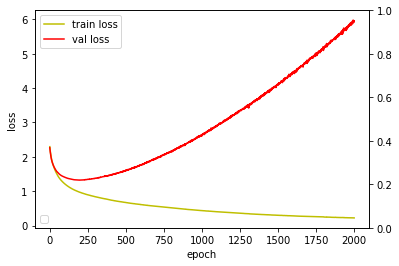

In [8]:
# train loss, val loss 시각화

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label = 'val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

validation loss가 처음엔 줄어들다가 일정 epoch 이상에서 계속 증가하고 있는것을 관찰할 수 있습니다.  
과대적합이 발생한 모습입니다. 

## 조기 종료 (Early Stopping)
과대적합을 방지하기 위해서는 적절한 시점에 학습을 종료시키는 [조기종료]를 이용합니다.  

Keras의 callback 함수인 조기종료를 이용하면 일정한 조건에서 학습을 바로 종료시킬 수 있습니다.  EarlyStopping()은 patience, monitor 두 개의 파라미터를 입력받습니다. 

- patience = n으로 지정하면, 값이 n번 연속으로 향상이 없으면 학습을 종료
- monitor : 어떤 값을 기준으로 하여 훈련 종료를 결정할 것인지를 입력받음 
  - 예를 들어 monitor = 'val_loss' 로 지정하면, validation loss가 이전 epoch보다 n번 연속으로 증가하면 학습을 종료


In [9]:
from keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


early_model = Sequential()
early_model.add(Dense(units = 2, input_dim = 28*28, activation = 'relu'))
early_model.add(Dense(units = 10, activation = 'softmax'))

early_model.compile(loss = 'categorical_crossentropy',
                    optimizer = 'Adam', metrics = ['accuracy'])

early_hist = early_model.fit(X_train, Y_train,
                 epochs = 2000, batch_size = 50, 
                 validation_data = (X_val, Y_val),
                 #조기종료
                 callbacks = [early_stopping], verbose=0)

No handles with labels found to put in legend.


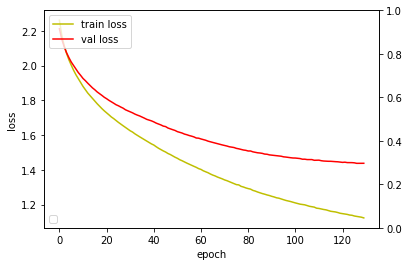

In [10]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(early_hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(early_hist.history['val_loss'], 'r', label = 'val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

위 그래프와 비교해 보았을 때, validation loss가 증가하기 전에 멈춘것을 관찰할 수 있음. 

## 가중치 규제
과대적합을 방지하기 위한 다른 전략은 [가중치 규제] 입니다. 가중치 규제는 다시 L1 규제, L2 규제로 나뉩니다.

가중치 규제를 추가한 후, 그 효과를 그래프로 확인해 보겠습니다.

In [11]:
from keras import regularizers

l2_model = Sequential()
l2_model.add(Dense(units=2,activation='relu',
                   #L2 규제 추가
                   kernel_regularizer=regularizers.l2(0.01), input_dim=28*28))
l2_model.add(Dense(units = 10, activation = 'softmax'))

l2_model.compile(loss = 'categorical_crossentropy',
                 optimizer = 'Adam', metrics = ['accuracy'])

l2_hist = l2_model.fit(X_train, Y_train,
                                epochs=2000, batch_size=50,
                                validation_data = (X_val, Y_val),
                                verbose=0)

No handles with labels found to put in legend.


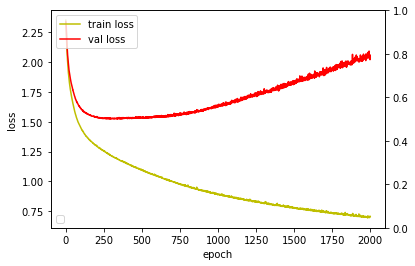

In [12]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(l2_hist.history['loss'], 'y', label = 'train loss')
loss_ax.plot(l2_hist.history['val_loss'], 'r', label = 'val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()